# Simbolic Regression Algorithm

In [553]:
import numpy as np
import random
from dataclasses import dataclass
from tqdm.auto import tqdm
from typing import List
import itertools
from evaluation import compute_FX
from utilities import mutation_unary_coeff, tune_constant, compute_unary_weights

In [554]:
problem = np.load('../data/problem_8.npz')
X = problem['x']
Y = problem['y']

DATA = X
LABELS = Y

print(DATA.shape)
print(LABELS.shape)

# COSTANTS
PROBLEM_SIZE = DATA.shape[0]
NUM_TOURNAMENTS = PROBLEM_SIZE*20
POPULATION_SIZE = PROBLEM_SIZE*20*NUM_TOURNAMENTS
OFFSPRING_SIZE = int((POPULATION_SIZE//NUM_TOURNAMENTS)*0.8)
MAX_GENERATIONS = 4000
TOURNAMENT_GENERATIONS = 50
INCREASE_COMPLEXITY_STEP = 500
# Problem size can be maximum 4 terms more then starting complexity
PROBLEM_COMPLEXITIES = [PROBLEM_SIZE+i for i in range(5)]

# higher complexity is less probable to be generated
PROBLEM_COMPLEXITIES_WEIGHTS = [PROBLEM_COMPLEXITIES[len(PROBLEM_COMPLEXITIES)-i-1]/sum(PROBLEM_COMPLEXITIES) for i in range(len(PROBLEM_COMPLEXITIES))]

(3, 5000)
(5000,)


In [555]:
# Reproducible random generator
rng = np.random.Generator(np.random.PCG64(42))

In [556]:
# Operators, variables and weights
BINARY_OPERATORS = ["+", "-", "*", "/"]
UNARY_OPERATORS = ["sin", "cos","tan", "exp", "log","arcsin","arccos","arctan","sqrt","abs","reciprocal"]
VARIABLES = ["X_"+str(i) for i in range(PROBLEM_SIZE)]
VARIABLES_WEIGHTS = [[1/len(VARIABLES) for _ in range(len(VARIABLES))]]
VARIABLES_MAP = {var: i for i,var in enumerate(VARIABLES)}

In [557]:
@dataclass
class Individual:
    genome: list
    fitness: tuple

### Operators weights handling

In [558]:
UNARY_OPERATORS_WEIGHTS = [compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) for i in range(PROBLEM_SIZE)]
UNARY_OPERATORS_MAP = {op: i for i,op in enumerate(UNARY_OPERATORS)}
BINARY_OPERATORS_WEIGHTS = [[1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS] for _ in range(PROBLEM_SIZE)]
BINARY_OPERATORS_MAP = {op: i for i,op in enumerate(BINARY_OPERATORS)}

In [559]:
def update_weights(genome, sync_factor, increase: bool):
    
    for i in range(len(genome) // 5):
        unary_term = genome[1 + 5 * i]
        binary_term = genome[4 + 5 * i]
        n_var = int(genome[3 + 5 * i].split("_")[1])  # Numero della variabile

        # Aggiorna i pesi per gli operatori unari
        if unary_term != "":
            unary_idx = UNARY_OPERATORS_MAP[unary_term]
            if increase:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] += sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] <= 0.65 else 0
            else:
                UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] -= sync_factor if UNARY_OPERATORS_WEIGHTS[n_var][unary_idx] >= 0.15 else 0
            # Normalizza i pesi
            UNARY_OPERATORS_WEIGHTS[n_var] /= np.sum(UNARY_OPERATORS_WEIGHTS[n_var])

        # Aggiorna i pesi per gli operatori binari
        binary_idx = BINARY_OPERATORS_MAP[binary_term]
        if increase:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] += sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] <= 0.65 else 0
        else:
            BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] -= sync_factor if BINARY_OPERATORS_WEIGHTS[n_var][binary_idx] >= 0.15 else 0
        # Normalizza i pesi
        BINARY_OPERATORS_WEIGHTS[n_var] /= np.sum(BINARY_OPERATORS_WEIGHTS[n_var])


### Genetic Program Logic

We have to find a combination of X (numpy array for data of size (n,m)) with numpy operands that gives as result Y (numpy array for labels of size (m,)). <br>
Each formula (genome) will have the form: 
<br><br>
_0 Opb,1 A * Opu,1(X1*Av) Opb,2 B * Opu,2(X2*Bv) ... Opb,i I * Opu,i(Xi*Iv) ...Opb,n N * Opu,n(Xn*Nv)_

- n: Problem size
- Xi: Variable of col i for each row data sample
- A, B, ..I, ..N: costants positive or negative that works as weights for the single term
- Av, Bv, ..Iv, ..Nv: positive constants that wights only the single variable 
- Opu,n(..): unary operators for one variable
- Opb,n: binary operators between two terms

If the fitness doesn't improve for a fixed number of generation a generic term is added, increasing the complexity to _(prev_n + 1)_ 

Example of formula expression for 2 variable problem:
["1", "", "1", "X_0", "+", "0.2", "sin","1", "X_1", "+"]

### Individual Generation

In [560]:
def generate_coefficient(X,Y):
    '''Generate a pseudo-random term coefficient according to inputs and outputs'''

    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_standardized = (X - X_mean) / X_std

    Y_mean = np.mean(Y)
    Y_std = np.std(Y)
    Y_standardized = (Y - Y_mean) / Y_std

    # compute correlations between x and Y
    correlations = np.corrcoef(X_standardized.T, Y_standardized)[:-1, -1]

    initial_coefficients = correlations * (Y_std / X_std)

    # Step 4: Generazione di valori casuali nel range
    random_coefficients = rng.choice(rng.uniform(0, np.abs(initial_coefficients), 1000),1)[0]

    if round(random_coefficients,4) != 0:
        random_coefficients = round(random_coefficients,4)
    return random_coefficients

In [561]:
def new_term(individual_gen:List,n,x,y):
    '''Generate a single term of the formula'''
    # i = 3
    var = rng.choice(VARIABLES,1 ,p=VARIABLES_WEIGHTS[0]) [0] 
    VARIABLES_WEIGHTS[0][VARIABLES_MAP[var]] = 0
    if np.sum(VARIABLES_WEIGHTS[0]) == 0:
        VARIABLES_WEIGHTS[0] = [1/len(VARIABLES) for _ in range(len(VARIABLES))]
    else:
        VARIABLES_WEIGHTS[0] /= np.sum(VARIABLES_WEIGHTS[0])

    # i = 0
    #costant = 1
    costant = 1 if rng.random()<0.2 else generate_coefficient(x[int(var.split("_")[1])],y)
    if np.any(y<0) and rng.random()<0.5: costant*=-1
    individual_gen.append(costant)

    # i = 1
    unary_op = "" if rng.random() < 0.2 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[int(var.split("_")[1])])[0])
    individual_gen.append(unary_op)

    # i = 2
    var_costant = 1 # the costant that multiply the variable start from 1
    individual_gen.append(var_costant)
    individual_gen.append(var)

    # i = 4
    bin_op = rng.choice(BINARY_OPERATORS,1) if n !=0 else rng.choice(["+","-"],1)
    individual_gen.append(str(bin_op[0]))

    return individual_gen

In [562]:
def generate_individual(x,y)->Individual:
    '''Generate a individual term by term'''
    individual_gen = []
    VARIABLES_WEIGHTS[0] = [1/len(VARIABLES) for _ in range(len(VARIABLES))]
    depth = rng.choice(PROBLEM_COMPLEXITIES,1,p=PROBLEM_COMPLEXITIES_WEIGHTS)[0]
    for n in range(depth):

        individual_gen = new_term(individual_gen,n,x,y)

    mse, _, right_sign, count, _ = compute_FX(individual_gen,x,y,PROBLEM_SIZE)    
    return Individual(individual_gen,(right_sign,-mse,count))

### Genetic selection

In [563]:
def parent_selection(population):
    '''Select 2 parents with a ranked based selection, with a fitness hole based on right-sign count'''
    # parent selection by rank, using a half fitness hole to prevent overfitting
    # e.g. first individual with rank 0 will have higher probability to be chosen
    rank_probs = [(len(population)-i-1)/sum(range(len(population))) for i in range(len(population))]
    
    if rng.random()<0.7:
        # best by mse (population is already sorted by mse)
        candidates = rng.choice(population, 5, replace=False, p = rank_probs)
    else:
        # best by right-sign count
        best_by_right_sign = sorted(population, key=lambda i: i.fitness[2], reverse=True)
        candidates = rng.choice(best_by_right_sign, 5, replace=False, p= rank_probs)
    
    selected_parents = rng.choice(candidates, 2, replace=False)

    return selected_parents

In [564]:
def survival_selection(population):
    '''Survival selection based on rank with fitness hole based on right-sign count'''
    # Rank based selection + fitness hole based on right-sign count
    new_population = []
    new_genomes = []
    for i in range(POPULATION_SIZE//NUM_TOURNAMENTS):
        if population[i].genome not in new_genomes:
            new_population.append(population[i])
            new_genomes.append(population[i].genome)
            if len(new_population) == (POPULATION_SIZE//NUM_TOURNAMENTS)//1.5:
                break
    population = sorted(population,key=lambda x : x.fitness[2],reverse=True)
    for i in range(POPULATION_SIZE//NUM_TOURNAMENTS):
        if population[i].genome not in new_genomes:
            new_population.append(population[i])
            new_genomes.append(population[i].genome)
            if len(new_population) == POPULATION_SIZE//NUM_TOURNAMENTS:
                break
    
    return new_population


### Genetic transformations

In [565]:
def xover(p1: Individual, p2: Individual, x, y) -> Individual:
    ''' Exchange terms between two individuals '''
    # Divide genomes into blocks
    blocks1 = [p1.genome[i:i + 5] for i in range(0, len(p1.genome), 5)]
    blocks2 = [p2.genome[i:i + 5] for i in range(0, len(p2.genome), 5)]
    if len(blocks2) >= len(blocks1):
        child_genome = p1.genome.copy()
    else:
        child_genome = p2.genome.copy()
    
    new_fitness = ()
    right_sign = p1.fitness[0] or p2.fitness[0]

    rep_factor = 0
    while rep_factor<0.5:
        sync_factor = 0.03 if right_sign else 0.01
        # Select random blocks to exchange
        xover_blocks = rng.choice(range(len(blocks2)), rng.integers(0.5, len(blocks2)), replace=False)

        # Exchange blocks
        for b_i in xover_blocks:
            i_xo = np.where(np.array(blocks1)==blocks2[b_i][3])[0]
            i_xo = rng.choice(i_xo,1)[0]
            blocks1[i_xo] = blocks2[b_i]

        # Rebuild child genome
        child_genome = [elem for block in blocks1 for elem in block]

        # Evaluate fitness
        new_mse, _, right_sign, count, _ = compute_FX(child_genome, x, y,PROBLEM_SIZE)
        new_fitness = (right_sign, -new_mse, count)

        # Update weights based on fitness
        if new_fitness > p1.fitness or new_fitness > p2.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)

        rep_factor = rng.random()

    return Individual(child_genome, new_fitness)


In [566]:
def mutation(p: Individual, mutation_factor: float ,x, y) :
    ''' Mutate terms of one individual '''
    child_genome = p.genome.copy()
    new_fitness = ()
    blocks = [child_genome[i:i + 5] for i in range(0, len(child_genome), 5)]
    right_sign = p.fitness[0]
    rep_factor=0
    
    while rep_factor<0.6:
        sync_factor = 0.05 if right_sign else 0.01
        # Define mutation probabilities
        mutation_probs = np.array([0.2, 0.3, 0.2, 0, 0.3]) if right_sign else np.array([0.25, 0.25, 0.25, 0, 0.25])

        # Select random blocks to mutate
        if len(blocks) == 1:
            mutate_blocks = [0]
        else:
            mutate_blocks = rng.choice(range(len(blocks)), rng.integers(1, len(blocks)), replace=False)

        for b_i in mutate_blocks:
            # Mutate elements in the block
            elems = rng.choice(5, size=rng.integers(1, 5), p=mutation_probs)
            n_var = int(blocks[b_i][3].split("_")[1])

            for e_i in elems:
                if e_i == 0:
                    #blocks[b_i][e_i] *= mutation_factor #if blocks[b_i][e_i] < 1e4 else rng.random()
                    blocks[b_i][e_i] = tune_constant(b_i,0,p.fitness,blocks,x,y,PROBLEM_SIZE)
                    if not right_sign: blocks[b_i][e_i]*=-1
                elif e_i == 1:
                    new_unary_op = "" if rng.random() < 0.15 else str(rng.choice(UNARY_OPERATORS,1,p=UNARY_OPERATORS_WEIGHTS[n_var])[0])
                    blocks[b_i][2] = mutation_unary_coeff(blocks[b_i][e_i],blocks[b_i][2],new_unary_op != blocks[b_i][e_i])

                    blocks[b_i][e_i] = new_unary_op
                    blocks[b_i][0] = tune_constant(b_i,0,p.fitness,blocks,x,y,PROBLEM_SIZE)
                 
                elif e_i == 2 and blocks[b_i][1] not in ["arccos","arcsin","arctan"]:
                    blocks[b_i][e_i] = mutation_unary_coeff(blocks[b_i][1],blocks[b_i][e_i])

                elif e_i == 4:
                    new_bin_op = rng.choice(BINARY_OPERATORS,1,p=BINARY_OPERATORS_WEIGHTS[n_var]) if b_i !=0 else rng.choice(["+","-"],1)
                    blocks[b_i][e_i] = str(new_bin_op[0])  
                else:
                    continue

        # Rebuild genome and compute fitness
        child_genome = [elem for block in blocks for elem in block]
        new_mse, increase, right_sign, count, inc_factor = compute_FX(child_genome, x, y, PROBLEM_SIZE)
        new_fitness = (right_sign, -new_mse, count)

        if new_fitness > p.fitness:
            update_weights(child_genome, sync_factor, increase=True)
            break
        else:
            update_weights(child_genome, sync_factor, increase=False)

        rep_factor = rng.random()

    return Individual(child_genome, new_fitness), mutation_factor

### GENETIC ALGORITHM

In [567]:
def EA_resolution(num_generations, population,x,y):
    history = []
    mutation_factor = 1
    n_no_improvement = 0
    #terms_added = 0
    champion = population[0]
    for i in range(num_generations):

        offspring = list()

        for _ in range(OFFSPRING_SIZE):
            
            p1,p2 = parent_selection(population)
            
            if rng.random() <0.15 and not champion.fitness[0]:
                o = xover(p1,p2,x,y)
            else:
                o,mutation_factor = mutation(p1,mutation_factor,x,y)

            offspring.append(o)

        population.extend(offspring)

        population = sorted(population, key=lambda i: i.fitness,reverse=True)
        population = survival_selection(population)

        if population[0].fitness > champion.fitness:
            champion = population[0]
            n_no_improvement = 0
        else:
            n_no_improvement += 1

        if n_no_improvement > INCREASE_COMPLEXITY_STEP:
            print("Early stopping, not finding better solutions")
            break
        elif n_no_improvement == int(INCREASE_COMPLEXITY_STEP//2):
            # reset weights to prevent overfitting
            print("Reset weights")
            for i in range(PROBLEM_SIZE):
                UNARY_OPERATORS_WEIGHTS[i] = compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) 
                BINARY_OPERATORS_WEIGHTS[i] = [1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS]

        history.append(population[0])

        if i % 250 == 0 and i!= 0:
            print(f"\t\tBest individual found at iteration {i}:")
            print(f"\t\t\t{champion.genome}")
            print(f"\t\t\t{champion.fitness}")
        
        if -champion.fitness[1]<1e-30:
            print(f"\t\t\tEarly stopping: Near Solution Found")
            break

    return champion, history, population

## TOURNAMENTS LOOP

The tournament loop aim is to generate N strong different individual for the initial population of the main genetic loop. <br>
Each turnament will have different initial population and different data to be trained.<br>
The number of generation is small in order to avoid overfitting on the given data, and provide a fast initial population generation.

In [568]:
POPULATION = [generate_individual(DATA,LABELS) for _ in range(POPULATION_SIZE)]
POPULATION = sorted(POPULATION,key= lambda x : x.fitness)
winners = []
histories = []
for i in range(NUM_TOURNAMENTS):
    TOURNAMENT_POP = POPULATION[(POPULATION_SIZE//NUM_TOURNAMENTS)*i:(POPULATION_SIZE//NUM_TOURNAMENTS)*(i+1)]
    TOURNAMENT_DATA = DATA[:,(DATA.shape[1]//NUM_TOURNAMENTS)*i:(DATA.shape[1]//NUM_TOURNAMENTS)*(i+1)]
    TOURNAMENT_LABELS = LABELS[(DATA.shape[1]//NUM_TOURNAMENTS)*i:(DATA.shape[1]//NUM_TOURNAMENTS)*(i+1)]

    winner, history, _ = EA_resolution(TOURNAMENT_GENERATIONS,TOURNAMENT_POP,TOURNAMENT_DATA,TOURNAMENT_LABELS)
    print(f"Winner of Tounament n {i+1}/{NUM_TOURNAMENTS}:\n\t {winner}")
    for i in range(PROBLEM_SIZE):
        UNARY_OPERATORS_WEIGHTS[i] = compute_unary_weights(UNARY_OPERATORS,i,DATA,LABELS) 
        BINARY_OPERATORS_WEIGHTS[i] = [1/len(BINARY_OPERATORS) for _ in BINARY_OPERATORS]
    winners.append(winner)
    histories.append(history)

# Synch winners fitnesses with all data
for i,w in enumerate(winners):
    mse, _, right_sign, count_right_sign, _ = compute_FX(w.genome, DATA,LABELS, PROBLEM_SIZE)
    w.fitness = (right_sign, -mse, count_right_sign)
    print(f"New fitness winner {i+1}")
    print(w.fitness)

Winner of Tounament n 1/60:
	 Individual(genome=[np.float64(4579829.761), 'exp', np.float64(-1.1789998000000004), np.str_('X_0'), '+', np.float64(1511135.6517), 'tan', np.float64(0.3829), np.str_('X_1'), '+', -1.0, 'abs', 1.1, np.str_('X_2'), '*', np.float64(432509.8389), 'tan', 1, np.str_('X_2'), '/', np.float64(1966239.2324), 'cos', np.float64(-1.0252), np.str_('X_1'), '+', np.float64(904657.7306), '', 1.3310000000000004, np.str_('X_0'), '+', np.float64(3393.1713), 'exp', 1.1, np.str_('X_1'), '+'], fitness=(np.False_, np.float64(-1437582168398057.0), np.int64(68)))
Winner of Tounament n 2/60:
	 Individual(genome=[np.float64(-1342454.2842), 'sin', 1, np.str_('X_0'), '-', np.float64(-690384.1293), '', np.float64(-0.40075200000000005), np.str_('X_2'), '-', -1.0, 'cos', 1, np.str_('X_1'), '-', np.float64(-1553364.291), 'arctan', 1, np.str_('X_2'), '-', np.float64(-952349.9265), '', 1.2100000000000002, np.str_('X_0'), '-', np.float64(-286841.2057), '', 1.1, np.str_('X_1'), '-', np.float64

# MAIN LOOP

The main loop start with a good population in terms of fitness. 
Thanks to the diversity of the population should learn the best traits from the tournaments winner.
The number of generation is high

In [569]:
print("Generating new competitors")
NEW_POPULATION = []
NEW_POPULATION.extend(winners)
print(NEW_POPULATION)

print("Starting final Tournament")
winner, history, _ = EA_resolution(MAX_GENERATIONS,NEW_POPULATION,DATA,LABELS)
print(f"Winner of Final Tounament : {winner}")

Generating new competitors
[Individual(genome=[np.float64(4579829.761), 'exp', np.float64(-1.1789998000000004), np.str_('X_0'), '+', np.float64(1511135.6517), 'tan', np.float64(0.3829), np.str_('X_1'), '+', -1.0, 'abs', 1.1, np.str_('X_2'), '*', np.float64(432509.8389), 'tan', 1, np.str_('X_2'), '/', np.float64(1966239.2324), 'cos', np.float64(-1.0252), np.str_('X_1'), '+', np.float64(904657.7306), '', 1.3310000000000004, np.str_('X_0'), '+', np.float64(3393.1713), 'exp', 1.1, np.str_('X_1'), '+'], fitness=(np.False_, np.float64(-2110915357345907.8), np.int64(3771))), Individual(genome=[np.float64(-1342454.2842), 'sin', 1, np.str_('X_0'), '-', np.float64(-690384.1293), '', np.float64(-0.40075200000000005), np.str_('X_2'), '-', -1.0, 'cos', 1, np.str_('X_1'), '-', np.float64(-1553364.291), 'arctan', 1, np.str_('X_2'), '-', np.float64(-952349.9265), '', 1.2100000000000002, np.str_('X_0'), '-', np.float64(-286841.2057), '', 1.1, np.str_('X_1'), '-', np.float64(192835.453), 'arctan', 1, np

## WINNER TUNING

The last step consists in tuning randomly the costant of the winner according to the fitness in order to find a better solution

In [570]:
def fine_tune_winner(winner: Individual, x, y):
    
    best_genome = winner.genome.copy()
    best_fitness = winner.fitness
    blocks = [best_genome[i:i + 5] for i in range(0, len(best_genome), 5)]
    n_no_inc = 0

    # tuning each costant
    def tune_constant(index,term, curr_genome, curr_fitness):
        mutation_factor = 1.002
        improve = True
        direction_changed = False
        while improve:

            blocks[index][term] *= mutation_factor  # Modify costant
            if round(blocks[index][term])!=0: 
                blocks[index][term] = round(blocks[index][term],4)
            new_genome = [elem for block in blocks for elem in block]
            new_mse, new_increase, right_sign, count, _ = compute_FX(new_genome, x, y, PROBLEM_SIZE)
            new_fitness = (right_sign, -new_mse, count)
            # Aggiorna la soluzione migliore
            if new_fitness > curr_fitness:
                curr_fitness = new_fitness
                curr_genome = new_genome
                mutation_factor/=mutation_factor
            else:
                blocks[index][term] /= mutation_factor  # revert change
                if not direction_changed:
                    direction_changed = True
                    mutation_factor = 0.998 # try to explore backward
                else: 
                    improve = False
        
        return curr_genome,curr_fitness

    # Fine-tuning for costants
    for i in tqdm(range(50000)):

        idxs = rng.choice(len(blocks),rng.integers(0.5,len(blocks)))

        for idx in idxs:
            if rng.random()<0.5:
                new_genome, new_fitness = tune_constant(idx,0, best_genome, best_fitness)  
            else:
                new_genome, new_fitness = tune_constant(idx,2, best_genome, best_fitness)
        
            if new_fitness > best_fitness:
                best_fitness = new_fitness
                best_genome = new_genome
                n_no_inc = 0
            else:
                n_no_inc += 1

        if i % 5000 == 0 and i != 0:
            print(best_genome)
            print(best_fitness)

        if n_no_inc > 1000:
            print("Early stopping")
            break

    print("New best fitness:", best_fitness)
    print("New best genome:", best_genome)
    return Individual(best_genome, best_fitness)


In [575]:
print("initial best")
print(winner.fitness)
w = fine_tune_winner(winner,DATA,LABELS)

initial best
(np.False_, np.float64(-806303319225512.0), np.int64(4587))


  2%|▏         | 932/50000 [00:00<00:45, 1069.59it/s]

Early stopping
New best fitness: (np.False_, np.float64(-794691879185622.9), np.int64(4577))
New best genome: [np.float64(-925477.1441883767), '', np.float64(-0.624248496993988), np.str_('X_2'), '-', np.float64(303494.72194388777), '', np.float64(-1.9002004008016034), np.str_('X_1'), '+', -2.1443887775551103, 'cos', np.float64(0.49695584778388796), np.str_('X_0'), '*', np.float64(-3006465.1912825652), 'arctan', 1.0854, np.str_('X_0'), '-']


In [572]:
from importlib import reload
import utilities
reload(utilities)

mse, _, _, _, _ = compute_FX(w.genome,X,Y,PROBLEM_SIZE, True)
formula = w.genome.copy()
print("Final Formula:")
print(utilities.convert_formula(formula))
print("Final MSE:")
print(mse)


Final Formula:
(((-(-905319.0352705411 * -0.6351703406813628 * x[2]) + (300479.10170340684 * -1.907815631262525 * x[1])) * (-2.1573146292585172 * np.cos(0.49695584778388796 * x[0]))) - (-3006465.1912825652 * np.arctan(1.0854 * x[0])))
Final MSE:
790738220509061.4


## Winner Visualization

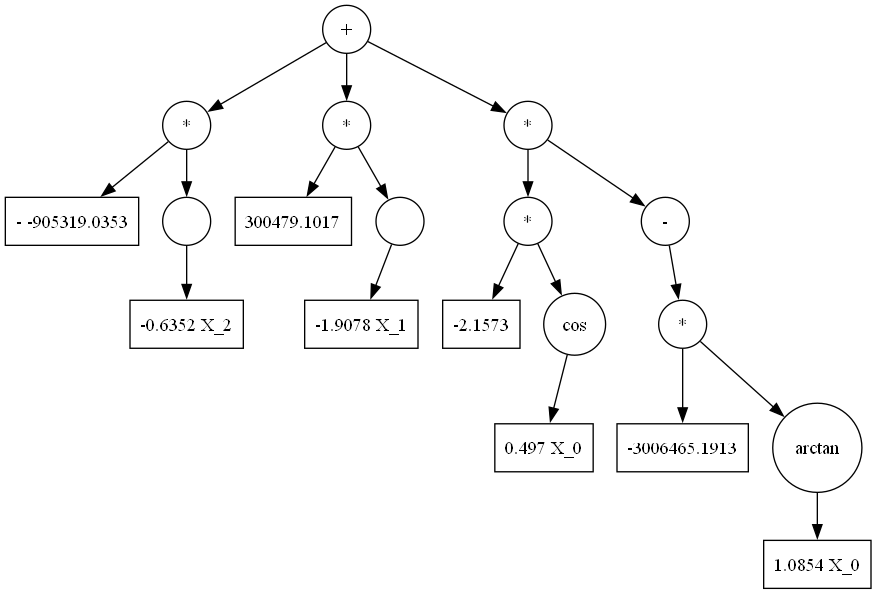

In [573]:
from importlib import reload
import visualization
import graphviz
from IPython.display import Image, display
reload(visualization)

graph = visualization.create_formula_graph(w.genome)
img = graph.pipe("png")
display(Image(img))

Text(0, 0.5, 'Count')

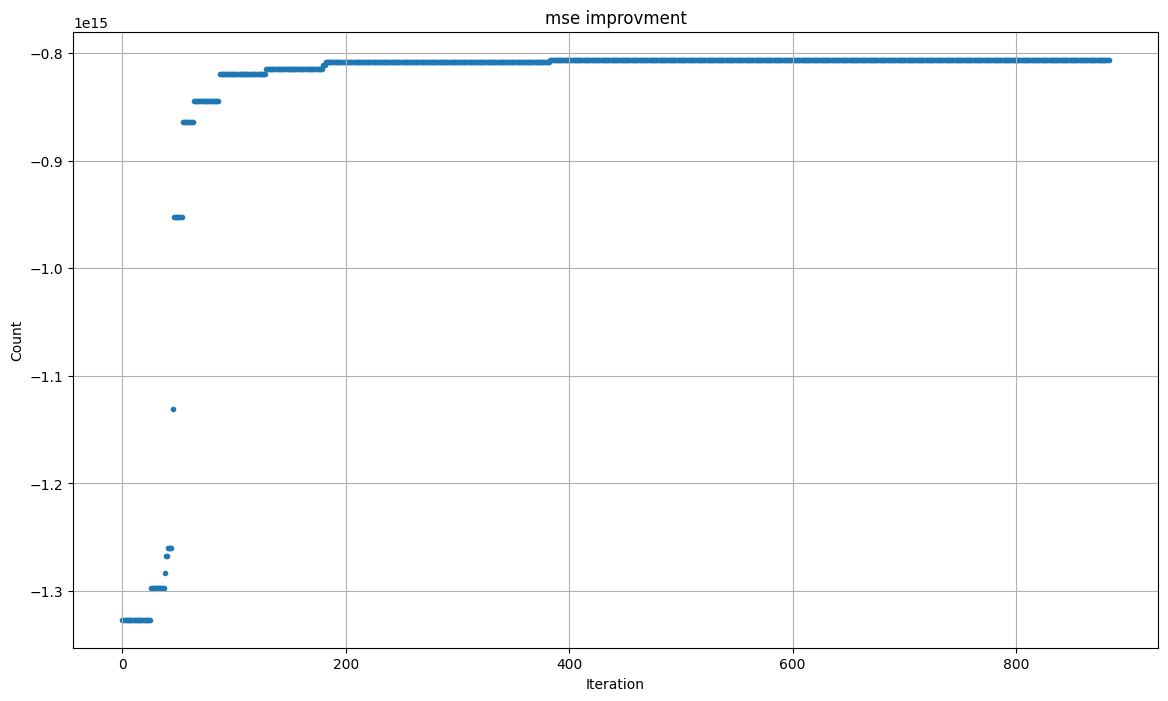

In [574]:
#from itertools import accumulate
from matplotlib import pyplot as plt

costs = [sol.fitness[1] for sol in history]
#Plot
plt.figure(figsize=(14, 8))             
plt.title("mse improvment")
plt.grid()

plt.scatter(range(len(costs)), costs, marker=".")

plt.xlabel('Iteration')
plt.ylabel('Count')